In [ ]:
# %pip install opencv-python
# %pip install opencv-python-headless

import cv2
import numpy as np
import matplotlib.pyplot as plt
from imageProcessing import detect_board_and_warp, split_board_into_cells

In [6]:
import re

input_img = 'evaluation/fake_test/1_02.jpg'
template_img = ["train/1_00.jpg", "train/2_00.jpg", "train/3_00.jpg", "train/4_00.jpg", "train/5_00.jpg"]  # your perfect board image
fake_test_template = "evaluation/fake_test/1_00.jpg" # your perfect board image
query_img = input_img              # skewed image

match = re.search(r'/(?P<number>\d+)_', input_img) # THIS MIGHT HAVE TO BE REMOVED WHEN PROJECT FINISHED AND SENT FOR EVALUATION}
img_num = 0
if match:
    img_num = match.group('number')
    #set to int
    img_num = int(img_num)

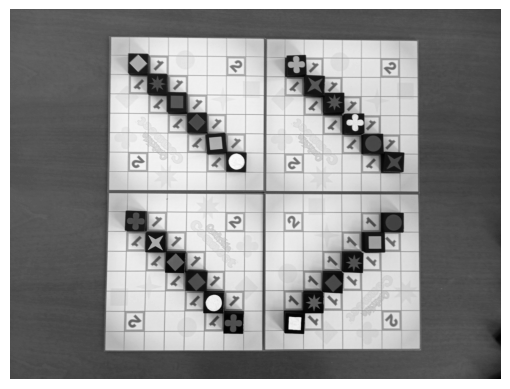

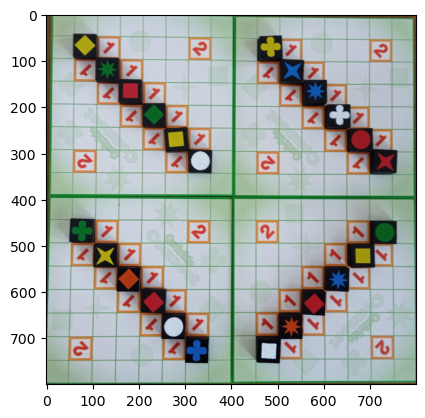

In [7]:
# warp template_img and show result
# warped_template = cv2.imread(template_img[img_num-1])
warped_template = cv2.imread(fake_test_template)
_, debug_lines, warped_template = detect_board_and_warp(warped_template, output_size=(800, 800))
plt.imshow(cv2.cvtColor(warped_template, cv2.COLOR_BGR2RGB))

# save warped template img
cv2.imwrite(f"warped_template.jpg", warped_template)
wrp_tmp_path = f"warped_template.jpg"

Contour extraction failed: Could not find a valid board contour.
[INFO] Good matches before filtering: 479


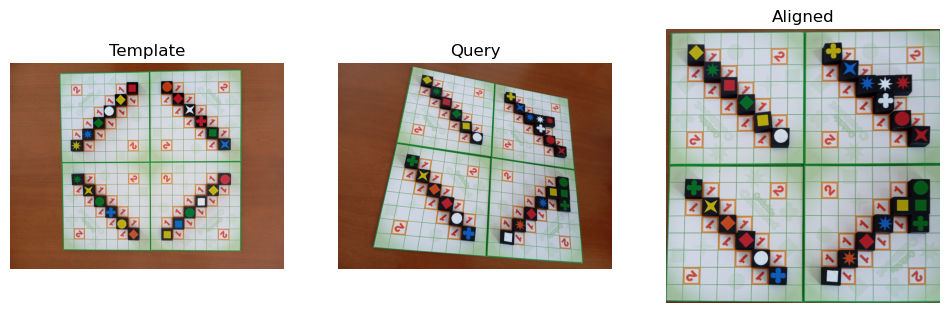

In [8]:
from imgAlignment import align_board, extract_board_by_contour

try:
    # Attempt to extract the board using contours
    aligned_img = extract_board_by_contour(query_img, output_size=(800, 800), debug=True)
except Exception as e:
    print(f"Contour extraction failed: {e}")
    tpl, qry, aligned_img, image_matches = align_board(wrp_tmp_path, query_img, output_size=(800,800), show_details=False , use_sift=True, homography_threshold=0.85)

plt.figure(figsize=(12,4))
# Read template and query images
template_img_array = cv2.imread(template_img[img_num - 1])  # Read the template image
if template_img_array is None:
    raise FileNotFoundError(f"Template image not found at path: {template_img[img_num - 1]}")

query_img_array = cv2.imread(query_img)  # Read the query image
if query_img_array is None:
    raise FileNotFoundError(f"Query image not found at path: {query_img}")

for i, img in enumerate([template_img_array, query_img_array, aligned_img], 1):
    plt.subplot(1, 3, i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(["Template", "Query", "Aligned"][i - 1])
plt.show()

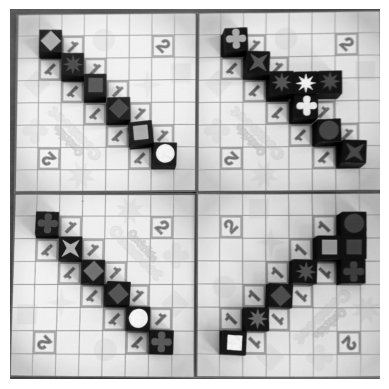

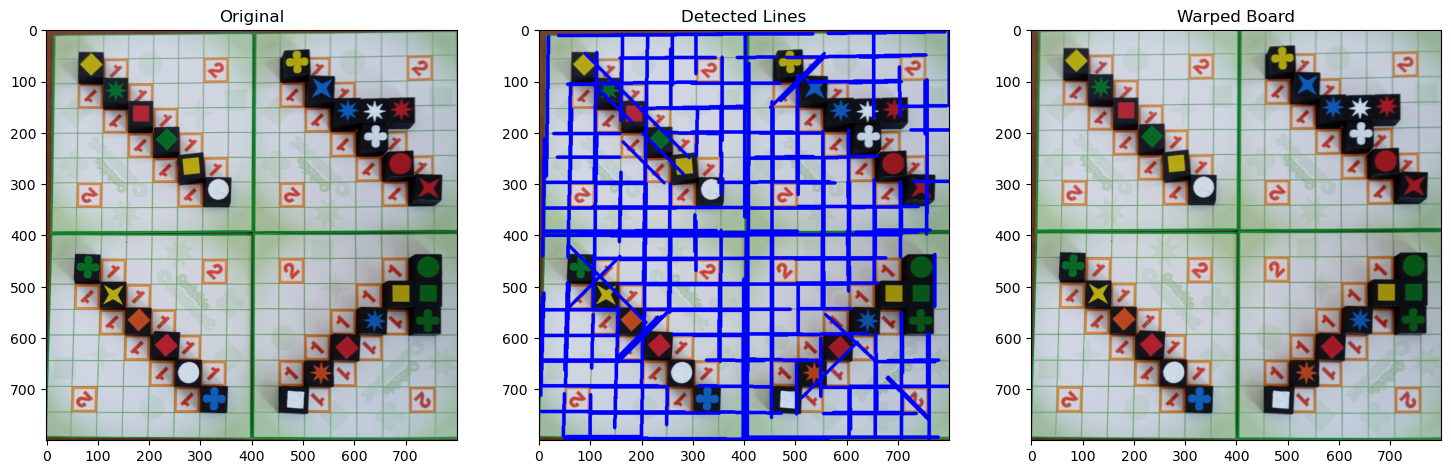

In [9]:
original, lines, warped = detect_board_and_warp(aligned_img)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.title("Detected Lines")
plt.imshow(cv2.cvtColor(lines, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 3)
plt.title("Warped Board")
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()

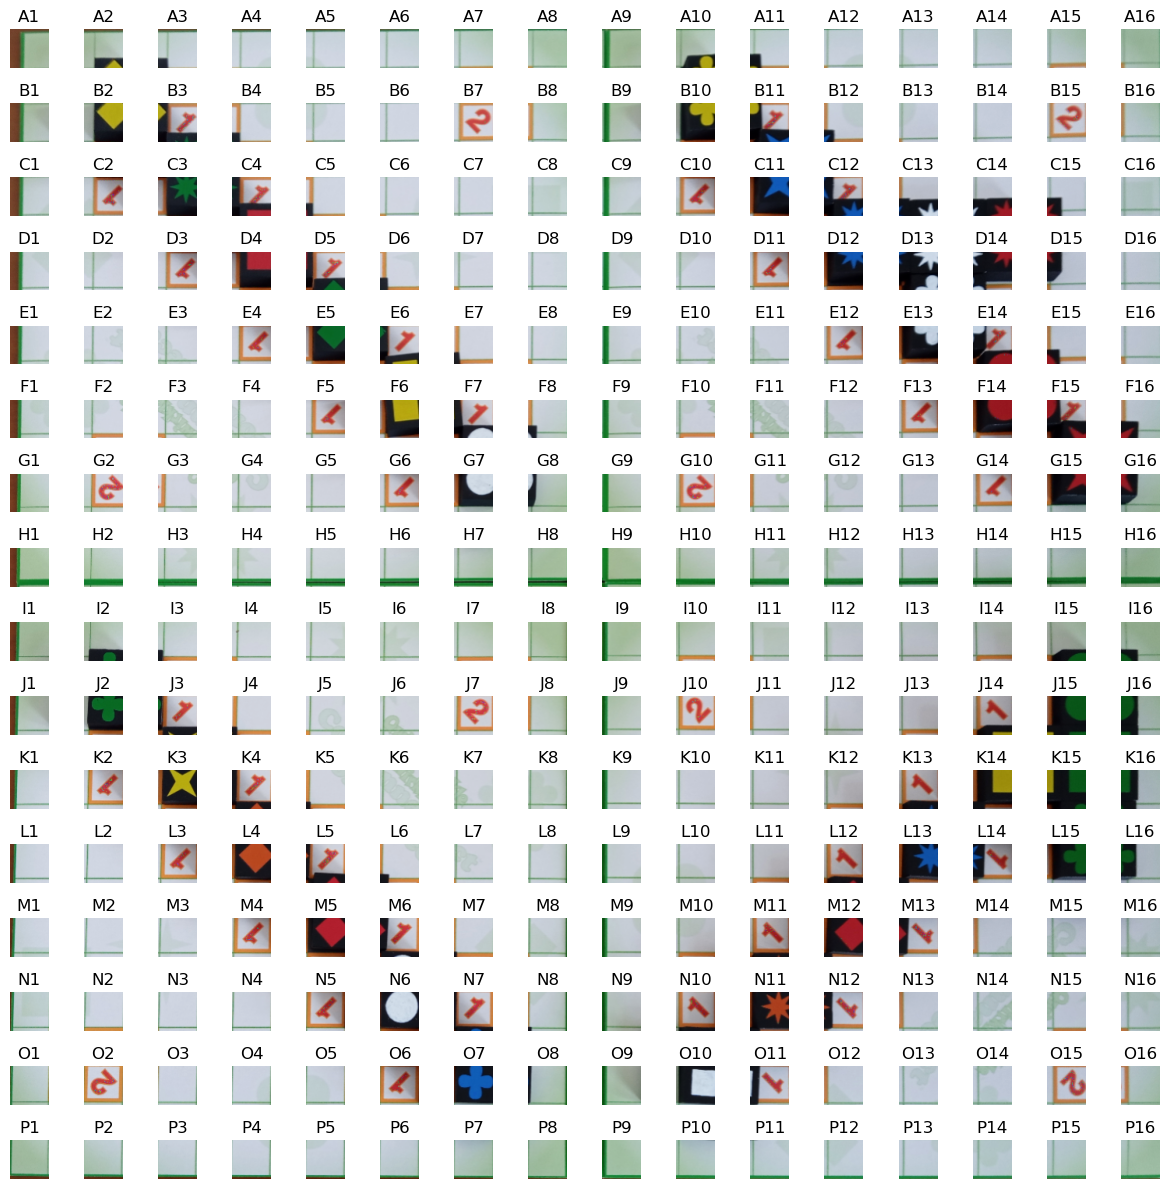

In [20]:
from board import Board

detection_grid = split_board_into_cells(warped, 16, padding=-0.15)
cells_grid = split_board_into_cells(warped, 16, padding=0)

board = Board()
# for label in cells_grid.keys():
    # board.add_cell(label, cells_grid[label])

plt.figure(figsize=(12, 12))
for i, (label, cell_img) in enumerate(list(cells_grid.items()), 1):
    plt.subplot(16, 16, i)
    plt.imshow(cv2.cvtColor(cell_img, cv2.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()



In [36]:
from tileDetection import is_tile_present

tiles = []
tiles_present = []

for label, cell_img in cells_grid.items():
    # Check if a tile is present in the current cell
    is_present = is_tile_present(cells_grid.get(label), threshold=64, min_foreground_ratio=0.35)
    
    # Add the tile information to the tiles list
    tiles.append({'label': label, 'isPresent': is_present, 'img': cell_img})
    
    # If a tile is present, add it to the tiles_present list
    if is_present:
        tiles_present.append({'label': label, 'isPresent': is_present, 'img': cell_img, 'detection_img': detection_grid.get(label)})
    

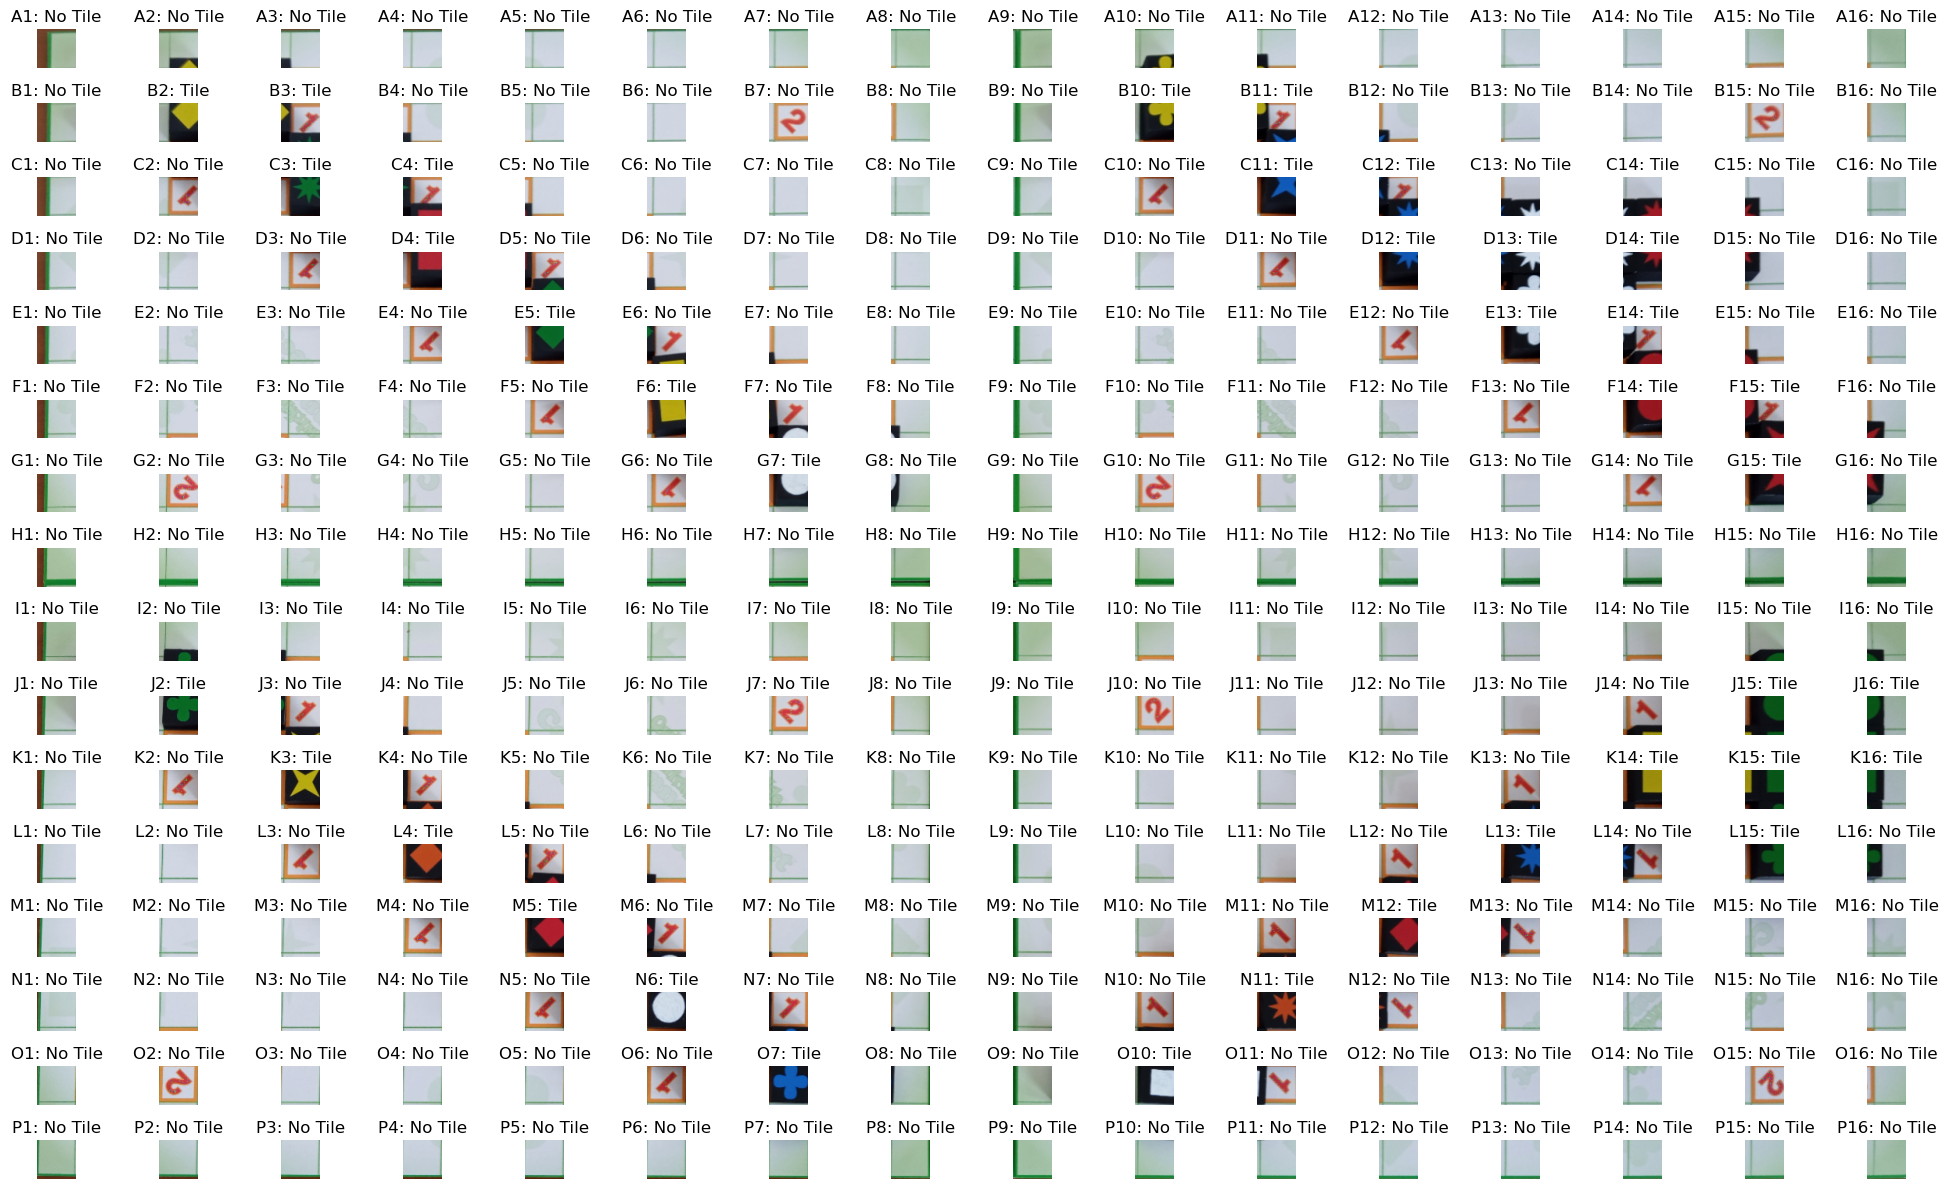

In [38]:
plt.figure(figsize=(20, 12))
for i, tile in enumerate(tiles, 1):
    label = tile['label']
    tile_present = tile['isPresent']
    plt.subplot(16, 16, i)
    plt.imshow(cv2.cvtColor(cells_grid[label], cv2.COLOR_BGR2RGB))
    plt.title(f"{label}: {'Tile' if tile_present else 'No Tile'}")
    plt.axis("off")
plt.tight_layout()

In [39]:
# %pip install torch
# %pip install torchvision

from DNN_shape_classifier import get_shape_model
import torch
import torchvision.transforms as transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = get_shape_model(num_classes=10)
classifier.load_state_dict(torch.load("resnet_shape.pt", map_location=device))
classifier.to(device)
classifier.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
shape_names = ["0", "7", "8", "circle", "clover", "diamond", "square", "star4", "star8"]

tiles_classified = []

for tile in tiles_present:
    if not tile['isPresent']:
        continue

    label = tile['label']
    patch_img = tile['img']

    if patch_img is None or not isinstance(patch_img, np.ndarray):
        print(f"[WARN] Invalid image at {label}")
        continue

    try:
        # Convert OpenCV image to PIL
        img_pil = Image.fromarray(cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB))
    except Exception as e:
        print(f"[ERROR] Failed to convert image at {label}: {e}")
        continue

    # Apply transform and predict
    input_tensor = transform(img_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        output = classifier(input_tensor)
        pred_idx = output.argmax(dim=1).item()
        shape = shape_names[pred_idx]

    print(f"Tile at {label}: {shape}")
    tiles_classified.append({'label': label, 'shape': shape, 'img': patch_img})
    

c:\Users\andre\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Tile at B2: star8
Tile at B3: 8
Tile at B10: star8
Tile at B11: clover
Tile at C3: star8
Tile at C4: clover
Tile at C11: star8
Tile at C12: star8
Tile at C14: 0
Tile at D4: clover
Tile at D12: star8
Tile at D13: star8
Tile at D14: star8
Tile at E5: star8
Tile at E13: star8
Tile at E14: star8
Tile at F6: star8
Tile at F14: star8
Tile at F15: star8
Tile at G7: star8
Tile at G15: star4
Tile at J2: clover
Tile at J15: star8
Tile at J16: diamond
Tile at K3: star8
Tile at K14: star8
Tile at K15: star8
Tile at K16: clover
Tile at L4: diamond
Tile at L13: star8
Tile at L15: star8
Tile at M5: diamond
Tile at M12: diamond
Tile at N6: 0
Tile at N11: star8
Tile at O7: clover
Tile at O10: clover


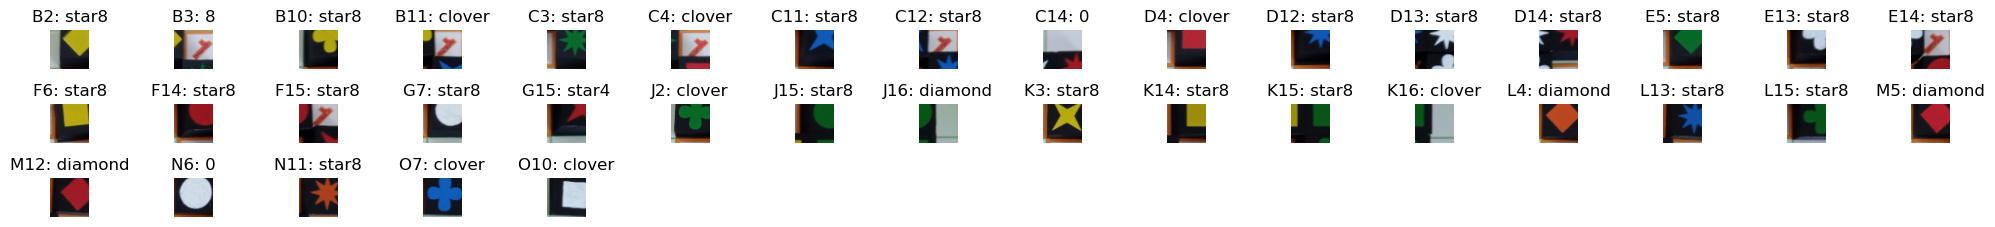

In [40]:
# plot images with preent tiles
plt.figure(figsize=(20, 12))
for i, tile in enumerate(tiles_classified, 1):
    label = tile['label']
    shape = tile['shape']
    plt.subplot(16, 16, i)
    plt.imshow(cv2.cvtColor(cells_grid[label], cv2.COLOR_BGR2RGB))
    plt.title(f"{label}: {shape}")
    plt.axis("off")
plt.tight_layout()

# # save tiles to tiles_dataset
# import os

# # Create a folder to save the tiles if it doesn't exist
# output_folder = "tiles_patches"
# os.makedirs(output_folder, exist_ok=True)

# # Iterate through the tiles_present list
# for tile in tiles_present:
#     label = tile['label']
#     tile_present = tile['isPresent']
#     if tile_present:  # Only save images where a tile is detected
#         # gray scale patches
#         # cells_grid[label] = cv2.cvtColor(cells_grid[label], cv2.COLOR_BGR2GRAY)
#         output_path = os.path.join(output_folder, f"{label}-4.jpg")
#         cv2.imwrite(output_path, cells_grid[label])  # Save the cell image

In [41]:
# Update tiles_present list with the classified shapes (remove shapes that are 0, 7, 8, 9)
tiles_present = [
	{**tile, 'shape': next((classified_tile['shape'] for classified_tile in tiles_classified if classified_tile['label'] == tile['label']), None)}
	for tile in tiles_present
	if next((classified_tile['shape'] for classified_tile in tiles_classified if classified_tile['label'] == tile['label']), None) not in ["0", "7", "8", "9"]
]

In [43]:
def map_color_to_name(color_bgr):
    # Simplified color label matching
    color_bgr = np.array(color_bgr)
    colors = {
        "red":     np.array([60, 60, 200]),
        "blue":    np.array([200, 60, 60]),
        "green":   np.array([60, 200, 60]),
        "yellow":  np.array([0, 220, 220]),
        "orange":  np.array([0, 140, 255]),
        # "purple":  np.array([150, 60, 150]),
        # "black":   np.array([0, 0, 0]),
        "white":   np.array([255, 255, 255]),
    }

    min_dist = float('inf')
    best_match = "unknown"
    for name, ref in colors.items():
        dist = np.linalg.norm(color_bgr - ref)
        if dist < min_dist:
            min_dist = dist
            best_match = name
    return best_match


In [42]:
from sklearn.cluster import KMeans
import cv2
import numpy as np

def extract_patch_color(image, row, col, grid_size=(6, 6), min_nonzero_pixels=30):
    h, w = image.shape[:2]
    patch_h, patch_w = h // grid_size[1], w // grid_size[0]

    x1 = col * patch_w
    y1 = row * patch_h
    patch = image[y1:y1 + patch_h, x1:x1 + patch_w]

    # Convert to HSV and apply mask to filter out background-like areas
    hsv = cv2.cvtColor(patch, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (0, 50, 50), (180, 255, 255))  # adjust as needed

    # Extract only valid pixels
    pixels = patch[mask > 0].reshape(-1, 3)

    if len(pixels) < min_nonzero_pixels:
        return "empty"

    # KMeans to get dominant color
    kmeans = KMeans(n_clusters=1, n_init='auto').fit(pixels)
    color = kmeans.cluster_centers_[0].astype(int)

    return map_color_to_name(color)


In [44]:
tiles_full_classified = []

for tile in tiles_present:
    if not tile['isPresent']:
        continue

    img = tile['img']
    shape = next((t['shape'] for t in tiles_classified if t['label'] == tile['label']), None)
    if shape is None:
        print(f"[WARN] Shape not found for tile {tile['label']}")
        continue

    try:
        # Detect color using extract_patch_color assuming 1 tile = 1 patch
        color = extract_patch_color(img, row=0, col=0, grid_size=(1, 1))  # full image = 1 patch
    except Exception as e:
        print(f"[ERROR] Failed color detection for tile {tile['label']}: {e}")
        color = "unknown"

    print(f"{tile['label']}: {color}")
    tiles_full_classified.append({'label': tile['label'], 'shape': shape, 'color': color, 'img': img})


B2: yellow
B10: red
B11: red
C3: green
C4: red
C11: blue
C12: blue
D4: red
D12: blue
D13: blue
D14: red
E5: green
E13: red
E14: red
F6: red
F14: red
F15: red
G7: red
G15: red
J2: green
J15: green
J16: green
K3: red
K14: red
K15: green
K16: green
L4: red
L13: blue
L15: green
M5: red
M12: red
N11: red
O7: blue
O10: blue


c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

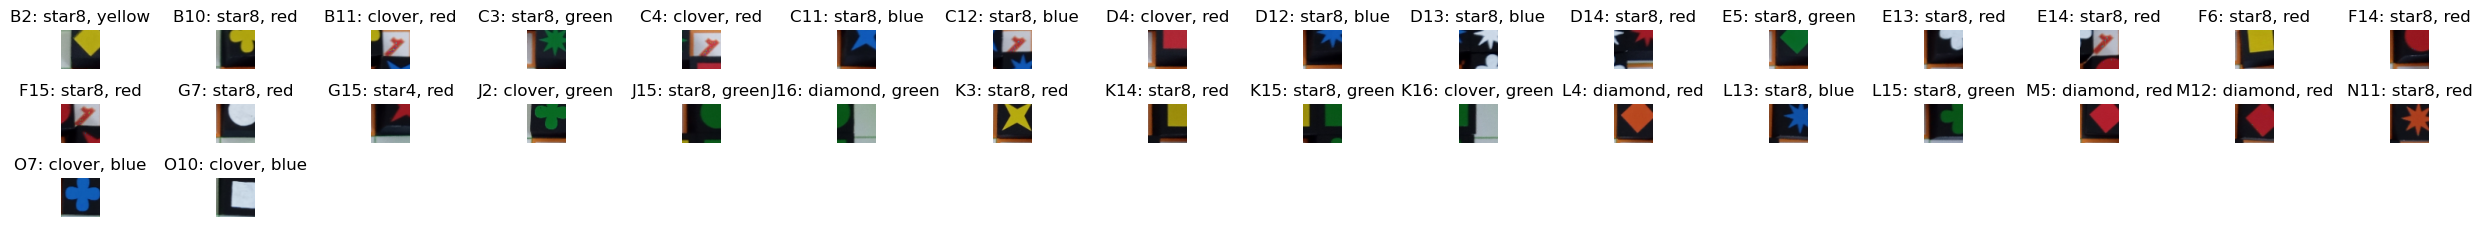

In [48]:
# plot pathces with tiles with both shape and color
plt.figure(figsize=(25, 12))
for i, tile in enumerate(tiles_full_classified, 1):
    label = tile['label']
    shape = tile['shape']
    color = tile['color']
    plt.subplot(16, 16, i)
    plt.imshow(cv2.cvtColor(cells_grid[label], cv2.COLOR_BGR2RGB))
    plt.title(f"{label}: {shape}, {color}")
    plt.axis("off")
plt.tight_layout()